## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [1]:
from get_windows import get_windows_with_GC_content_and_cpg_islands 

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools


,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## Metrics that account for class-balance variability across bins yield contradictory results

feature_mean	r	1-r	FDR	FDR/(1-r)
0.40393564982912245	0.3074774984276128	0.6925225015723873	0.5218582508606711	0.7535614361638512

feature_bin	feature_mean	r	precision	precision/r	1-r	FDR	FDR/(1-r)
(0.212, 0.313]	0.2972284092771273	0.09776354966531599	0.18674314850223073	1.9101510649063762	0.902236450334684	0.8132568514977693	0.9013788471925427
(0.313, 0.412]	0.3685397911251422	0.2359381705065268	0.34529020961013546	1.4634775240854199	0.7640618294934732	0.6547097903898645	0.8568806412223178
(0.412, 0.512]	0.45091864995558006	0.40346309219826454	0.5016345264826311	1.243321969673807	0.5965369078017355	0.49836547351736893	0.8354310806247804
(0.512, 0.612]	0.5426352680439778	0.5787934603041984	0.6450510430537062	1.114475347932723	0.4212065396958016	0.3549489569462938	0.8426957406754428
(0.612, 0.711]	0.6333921207903008	0.7000449034575662	0.7296809151113787	1.0423344438441569	0.2999550965424338	0.27031908488862133	0.9011985060583229


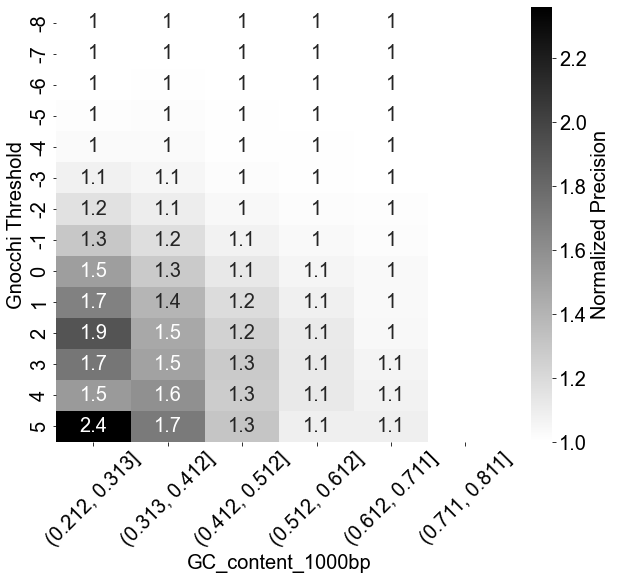

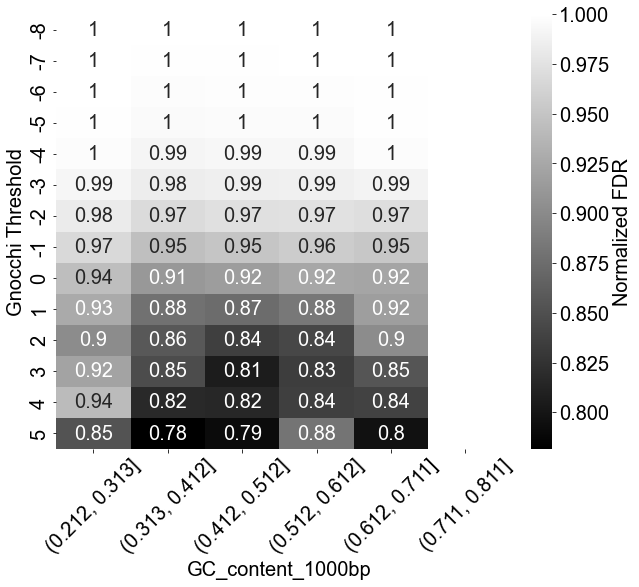

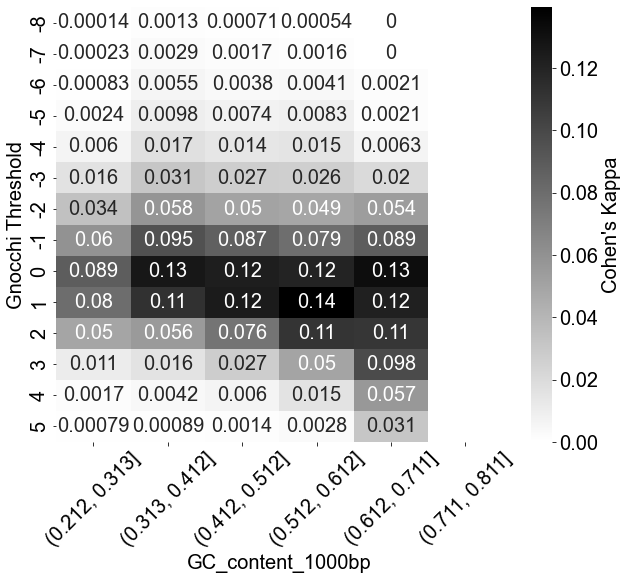

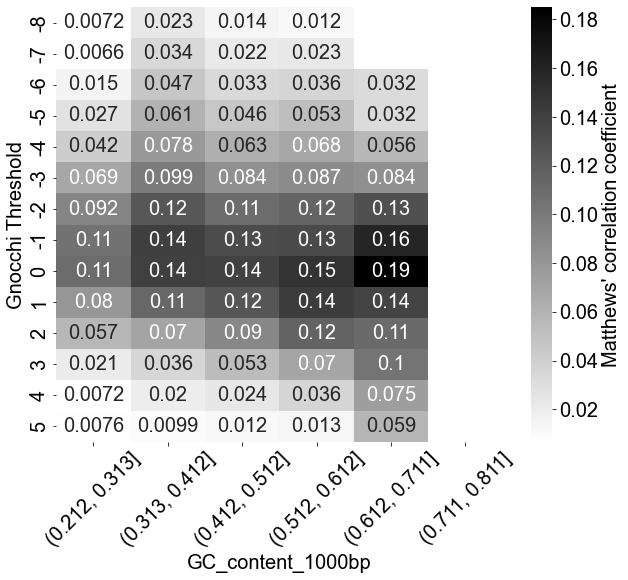

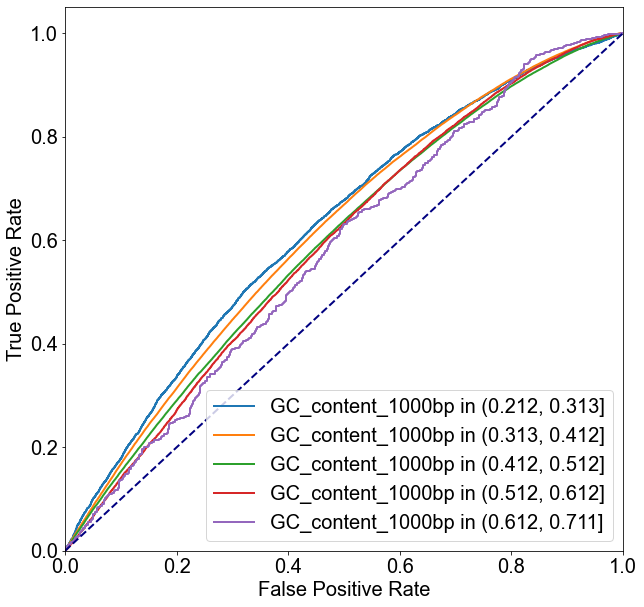

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import math

plt.rcParams.update({
    'font.size': 20,
    'font.family': 'arial',
    'figure.figsize': (12, 6)
})

def plot_heat_maps(df, feature='GC_content_1000bp'): 
  df = df.copy()

  gnocchi_threshold = 2
  TP = df[
    (df['gnocchi'] > gnocchi_threshold) & 
    (df['window overlaps enhancer'] == True)
  ].shape[0]
  FP = df[
    (df['gnocchi'] > gnocchi_threshold) & 
    (df['window overlaps enhancer'] == False)
  ].shape[0]
  precision = TP / (TP + FP)
  FDR = 1 - precision
  r = df['window overlaps enhancer'].mean()
  list_of_objects = [df[feature].mean(), r, 1-r, FDR, FDR/(1-r)]
  list_of_strings = list(map(str, list_of_objects))
  print('\t'.join(['feature_mean', 'r', '1-r', 'FDR', 'FDR/(1-r)']))
  print('\t'.join(list_of_strings))

  df[f'{feature}_bin'] = pd.cut(df[feature], bins=6)
  feature_bins = np.sort(df[f'{feature}_bin'].unique())

  gnocchi_thresholds = range(-8, 6)

  normalized_precision_df = pd.DataFrame(index=gnocchi_thresholds, columns=feature_bins).astype(float)
  normalized_FDR_df = pd.DataFrame(index=gnocchi_thresholds, columns=feature_bins).astype(float)
  cohens_kappa_df = pd.DataFrame(index=gnocchi_thresholds, columns=feature_bins).astype(float)
  mcc_df = pd.DataFrame(index=gnocchi_thresholds, columns=feature_bins).astype(float)

  fprs = []
  tprs = []

  print()
  print('\t'.join(['feature_bin', 'feature_mean', 'r', 'precision', 'precision/r', '1-r', 'FDR', 'FDR/(1-r)']))
  for feature_bin in feature_bins:
    df_feature_bin = df[df[f'{feature}_bin'] == feature_bin]
    if len(df_feature_bin) < 1000: continue 

    r = df_feature_bin['window overlaps enhancer'].mean()

    # ROC curve
    true_label = df_feature_bin['window overlaps enhancer']
    score = df_feature_bin['gnocchi']
    fpr, tpr, _ = roc_curve(true_label, score)
    fprs.append(fpr)
    tprs.append(tpr)

    for gnocchi_threshold in gnocchi_thresholds:

      TP = df_feature_bin[
        (df_feature_bin['gnocchi'] > gnocchi_threshold) & 
        (df_feature_bin['window overlaps enhancer'] == True)
      ].shape[0]
      FP = df_feature_bin[
        (df_feature_bin['gnocchi'] > gnocchi_threshold) &
        (df_feature_bin['window overlaps enhancer'] == False)
      ].shape[0]
      TN = df_feature_bin[
        (df_feature_bin['gnocchi'] <= gnocchi_threshold) &
        (df_feature_bin['window overlaps enhancer'] == False)
      ].shape[0]
      FN = df_feature_bin[
        (df_feature_bin['gnocchi'] <= gnocchi_threshold) &
        (df_feature_bin['window overlaps enhancer'] == True)
      ].shape[0]

      # compute Cohen's kappa
      # https://en.wikipedia.org/wiki/Cohen%27s_kappa
      # https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9440903
      p_o = (TP + TN) / (TP + TN + FP + FN)
      p_e = ((TP + FP) * (TP + FN) + (TN + FP) * (TN + FN)) / (TP + TN + FP + FN)**2
      cohens_kappa = (p_o - p_e) / (1 - p_e)
      cohens_kappa_df.loc[gnocchi_threshold, feature_bin] = cohens_kappa

      # compute Matthews' correlation coefficient
      # https://en.wikipedia.org/wiki/Phi_coefficient
      # https://chatgpt.com/share/740788b6-7caa-4c19-9fd0-bf8b59d82c05
      try: 
        MCC = (TP*TN - FP*FN) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
        mcc_df.loc[gnocchi_threshold, feature_bin] = MCC
      except ZeroDivisionError:
        mcc_df.loc[gnocchi_threshold, feature_bin] = None

      # compute precision and FDR 
      precision = TP / (TP + FP)
      FDR = 1 - precision
      normalized_precision_df.loc[gnocchi_threshold, feature_bin] = precision/r
      normalized_FDR_df.loc[gnocchi_threshold, feature_bin] = FDR/(1-r)
      if gnocchi_threshold == 2:
        list_of_objects = [feature_bin, df_feature_bin[feature].mean(), r, precision, precision/r, 1-r, FDR, FDR/(1-r)]
        list_of_strings = list(map(str, list_of_objects))
        print('\t'.join(list_of_strings))

  # Heatmap for Normalized Precision
  plt.figure(figsize=(10, 8))
  ax = sns.heatmap(normalized_precision_df, annot=True, cmap='binary')
  colorbar = ax.collections[0].colorbar
  colorbar.set_label('Normalized Precision')
  plt.xlabel(feature)
  plt.ylabel('Gnocchi Threshold')
  plt.xticks(rotation=45)  
  plt.show()

  # Heatmap for Normalized FDR
  plt.figure(figsize=(10, 8))
  ax = sns.heatmap(normalized_FDR_df, annot=True, cmap='binary_r')
  colorbar = ax.collections[0].colorbar
  colorbar.set_label('Normalized FDR')
  plt.xlabel(feature)
  plt.ylabel('Gnocchi Threshold')
  plt.xticks(rotation=45)  
  plt.show()

  # Heatmap for Cohen's Kappa
  plt.figure(figsize=(10, 8))
  ax = sns.heatmap(cohens_kappa_df, annot=True, cmap='binary')
  colorbar = ax.collections[0].colorbar
  colorbar.set_label("Cohen's Kappa")
  plt.xlabel(feature)
  plt.ylabel('Gnocchi Threshold')
  plt.xticks(rotation=45)  
  plt.show()

  # Heatmap for Matthews' correlation coefficient
  plt.figure(figsize=(10, 8))
  ax = sns.heatmap(mcc_df, annot=True, cmap='binary')
  colorbar = ax.collections[0].colorbar
  colorbar.set_label("Matthews' correlation coefficient")
  plt.xlabel(feature)
  plt.ylabel('Gnocchi Threshold')
  plt.xticks(rotation=45)
  plt.show()

  plt.figure(figsize=(10, 10))
  lw = 2
  for fpr, tpr, feature_bin in zip(fprs, tprs, feature_bins):
    plt.plot(fpr, tpr, lw=lw, label=f'{feature} in {feature_bin}')
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()    

plot_heat_maps(WINDOWS)